## Here we try to sample using Black Jax which include HMC/NUTS/Tempered Hamiltonian

In [ ]:
# !pip install numpy
# !pip install jax 
# !pip install blackjax
# !pip install estival
# !pip install PyYaml
# !pip install pandas
# !pip install nbformat --upgrade

# %pip install jax jaxlib
# !pip install pymc
# !pip install --upgrade --force-reinstall mingw
# %pip --upgrade m2w64-toolchain

In [1]:
import numpy as np
import jax.numpy as jnp
import blackjax
import blackjax.smc.resampling as resampling
import pandas as pd
import jax
import pymc as pm
import time as time

from datetime import date
import arviz as az
import matplotlib.pyplot as plt
from collections import namedtuple



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Combining tagets and prior with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel

from calibs_utilities import get_all_priors, get_targets, load_data

from models.models import model1 #All the models we design for the test


c:\Users\abdou\Desktop\M2-Scientique-Computing\Internship\Coding\.conda\Lib\site-packages\computegraph\jaxify.py:37: UserWarning: Could not import jax, model performance will be limited
  warnings.warn("Could not import jax, model performance will be limited")


## Importing our taget and prior data

In [3]:
pd.options.plotting.backend = "plotly"
output_labels = {"index": "time", "value": "number infectious"}

targets_yml = './data/target_yml.yml'
targets = load_data(targets_yml)
targets_data = targets['active_cases']



#Names of parameters and their ranges for the priors definitions
params = {
    "contact_rate": (0.0,0.5),
    "recovery_rate": (0.0,0.8)

}

targets = get_targets(targets_yml)
priors = get_all_priors(params)

targets_data.plot(kind="scatter",labels=output_labels)

## Building a BCM model with estival

In [4]:
model_1 = model1()
default_params = {
    "contact_rate": 0.5,
    "recovery_rate": 0.0,
    #"active_cases_dispersion": 0.5,
}
bcm = BayesianCompartmentalModel(model_1, default_params,priors, targets)



### LogLiklihood definition from the bcm model

In [5]:
params_tuple = namedtuple("model_params", ["contact_rate", "recovery_rate"])


#Defining a callable Loglikelihood from the bcm model
def Loglikehood(params_tuple):
        params = {'contact_rate': params_tuple.contact_rate, 'recovery_rate': params_tuple.recovery_rate}  #, 'cdr': 0.2}
        val = bcm.loglikelihood(**params)
        return val.astype(float)

### Initial parameters

In [6]:
## Initial parameters for the chains
# For we initialise with default chosen constant values for all chains
# We can later experiment a Uniform initialisation

def init_param_fn(n_chains): #Permet d'initialiser les parametres pour chaque chaine 
    """
    initialize recovery_rate & contact_rate for the chains 
    """
    return params_tuple(
       contact_rate = jnp.ones(n_chains)*0.15,
        recovery_rate = jnp.ones(n_chains)*0.05, 
    )


In [7]:
n_chains = 4

init_params = init_param_fn(n_chains)

#Checking result with jax vmap to map the function to multiple args
jax.vmap(Loglikehood)(init_params)



Array([-3.5710104e+10, -3.5710104e+10, -3.5710104e+10, -3.5710104e+10],      dtype=float32)

### Now we use blackjax’s window adaption algorithm to get NUTS kernel and initial states. Window adaption algorithm will automatically configure inverse_mass_matrix and step size

In [26]:
%%time
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
rng_key, warmup_key = jax.random.split(rng_key, 2)

warmup = blackjax.window_adaptation(blackjax.hmc, logdensity_fn = Loglikehood,**dict(num_integration_steps = 50))

# we use 4 chains for sampling
@jax.vmap
def call_warmup(seed, param):
    (initial_states, tuned_params), _ = warmup.run(seed, param, 50)
    return initial_states, tuned_params


warmup_keys = jax.random.split(warmup_key, n_chains)

initial_states, tuned_params = jax.jit(call_warmup)(warmup_keys, init_params)



CPU times: total: 10.2 s
Wall time: 27 s


## Sampling wiht HMC from BlackJax

#### An inference loop for multiple chains sampling

In [28]:
def inference_loop_multiple_chains(
    rng_key, initial_states, tuned_params, log_prob_fn, num_samples, num_chains
):
    kernel = blackjax.hmc.build_kernel()
    @jax.jit  #Comment to ass the performance
    def step_fn(key, state, **params):
        return kernel(key, state, log_prob_fn, **params)

    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, infos = jax.vmap(step_fn)(keys, states, **tuned_params)
        return states, (states, infos)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_states, keys)

    return (states, infos)


#### Sampling process

Slow process. Has to be run in parallel

In [33]:
%%time
n_samples = 1000
rng_key, sample_key = jax.random.split(rng_key)

states, infos = inference_loop_multiple_chains(
        rng_key = sample_key,
        initial_states =  initial_states,
        tuned_params = tuned_params,
        log_prob_fn = Loglikehood,
        num_samples = n_samples,
        num_chains = n_chains,
)

CPU times: total: 1min 26s
Wall time: 4min 13s


### Derived the trace from the outputs of our sampler

In [35]:
def arviz_trace_from_states(states, info, burn_in=0):
    position = states.position
    if isinstance(position, jax.Array):  # if states.position is array of samples
        position = dict(samples=position)
    else:
        try:
            position = position._asdict()
        except AttributeError:
            pass

    samples = {}
    for param in position.keys():
        ndims = len(position[param].shape)
        if ndims >= 2:
            samples[param] = jnp.swapaxes(position[param], 0, 1)[
                :, burn_in:
            ]  # swap n_samples and n_chains
            divergence = jnp.swapaxes(info.is_divergent[burn_in:], 0, 1)

        if ndims == 1:
            divergence = info.is_divergent
            samples[param] = position[param]

    trace_posterior = az.convert_to_inference_data(samples)
    trace_sample_stats = az.convert_to_inference_data(
        {"diverging": divergence}, group="sample_stats"
    )
    trace = az.concat(trace_posterior, trace_sample_stats)
    return trace

In [36]:
# make arviz trace from states
trace = arviz_trace_from_states(states, infos)
summ_df = az.summary(trace)
summ_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
contact_rate,0.138,0.014,0.125,0.162,0.007,0.005,4.0,4.0,3.58
recovery_rate,0.181,0.010,0.166,0.193,0.005,0.004,5.0,4.0,2.32


In [14]:
trace

Inference data with groups:
	> posterior
	> sample_stats

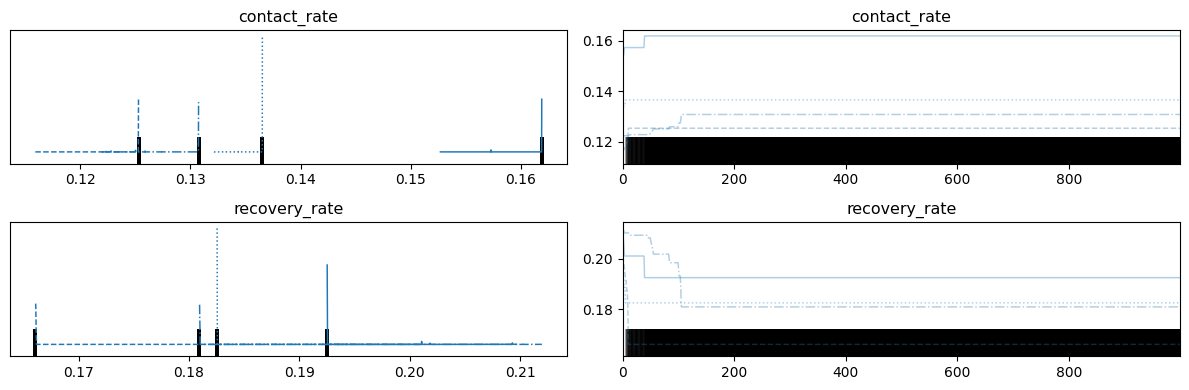

In [37]:
az.plot_trace(trace)
plt.tight_layout()